In [13]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=200)
plt.rc('legend', fontsize=9)
import warnings
warnings.filterwarnings('ignore')

In [26]:
def concatenate_performance(dir_path):
    path = Path(dir_path)
    (_, dir_names, _) = next(os.walk(path))  # Get subdirectories
    memmaps = []
    for sweep_dir in [d for d in dir_names if d.startswith("sweep")]:  # Filter for "sweep" prefix
        # Open the performance memmaps in each subdirectory:
        memmaps.append(np.lib.format.open_memmap(str(path / sweep_dir / 'performance.npy'), mode='r'))
    concatenated = np.concatenate(memmaps)  # concatenate all memmaps together (note: loads them all into memory)
    performance_memmap = np.lib.format.open_memmap(str(path / 'concatenated_performance.npy'), shape=concatenated.shape, dtype=concatenated.dtype, mode='w+')
    performance_memmap[:] = concatenated
    del memmaps
    del concatenated
    del performance_memmap
    
def combine_results(results):
    num_configs, num_runs, num_policies, num_evals = results.shape
    mean_evals = np.mean(results, axis=3)
    mean_runs = np.mean(mean_evals, axis=1)
    sem_runs = st.sem(mean_evals, axis=1)
    lower, upper = np.nan_to_num(st.t.interval(0.95, num_runs-1, loc=mean_runs, scale=sem_runs), nan=-1000)
    return mean_runs, lower, upper

def load_results(alg):
    return np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw_100ksteps_30runs/bias/'+alg+'/concatenated_performance.npy', mode='r')

In [19]:
etd_algs = ['ace-trace-etd-episodic', 'ace-trace-etd-uniform', 'offpac-etd', 'ace-direct-etd-episodic', 'ace-direct-etd-uniform', 'ace-ideal-etd-episodic', 'ace-ideal-etd-uniform']
tdrc_algs = ['ace-trace-tdrc-episodic', 'ace-trace-tdrc-uniform', 'offpac-tdrc', 'ace-direct-tdrc-episodic', 'ace-direct-tdrc-uniform', 'ace-ideal-tdrc-episodic', 'ace-ideal-tdrc-uniform']
algs = etd_algs + tdrc_algs
# for alg in algs:
#     print(alg)
#     concatenate_performance('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings//' + alg)

ace-trace-etd-episodic -1019.0413548823668
ace-trace-etd-uniform -393.9555393950642
offpac-etd -219.2806355328281
ace-direct-etd-episodic -152.17965891318573
ace-direct-etd-uniform -189.8527709491317
ace-ideal-etd-episodic -979.5168453264907
ace-ideal-etd-uniform -340.3343169406388


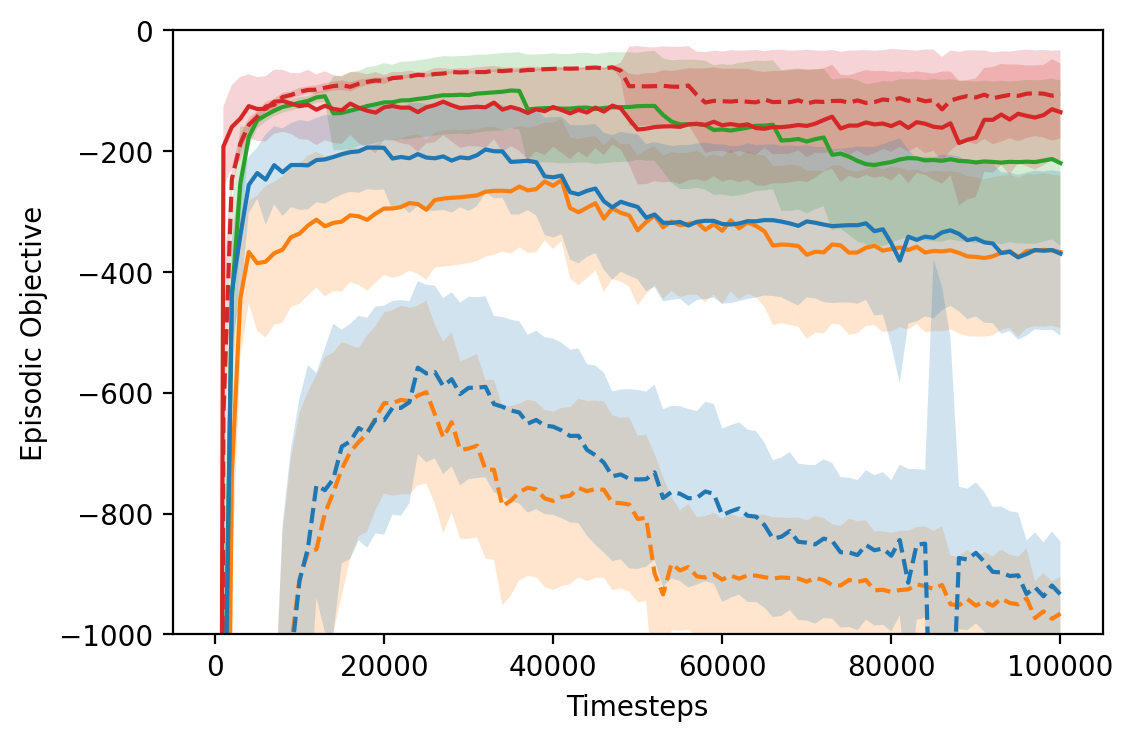

In [29]:
fig, ax = plt.subplots()
for alg in etd_algs:
    results = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw_100ksteps_30runs/bias/eval_episodic/'+alg+'/sweep0/performance.npy', mode='r')['results']
    means, lower, upper = combine_results(results)
    best_config = np.nanargmax(means.sum(axis=1))
    print(alg, np.nanmax(means.mean(axis=1)))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    if 'direct' in alg:
        color = 'tab:red'
#         if 'uniform' in alg:
#             ax.annotate(alg, xy=(-2000, -110), color=color)
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(28000, -1000), xytext=(10000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'trace' in alg:
        color = 'tab:orange'
#         if 'uniform' in alg:
#             ax.annotate(alg, xy=(21500, -345), xytext=(20000, -480), color=color, arrowprops=dict(arrowstyle="->", color=color))
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(80000, -1000), xytext=(60000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
#         ax.annotate(alg, xy=(5500, -600), xytext=(15000, -700), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'ideal' in alg:
        color = 'tab:blue'
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(-1000,0)
plt.savefig('pw_epi_etd.png', bbox_inches="tight")

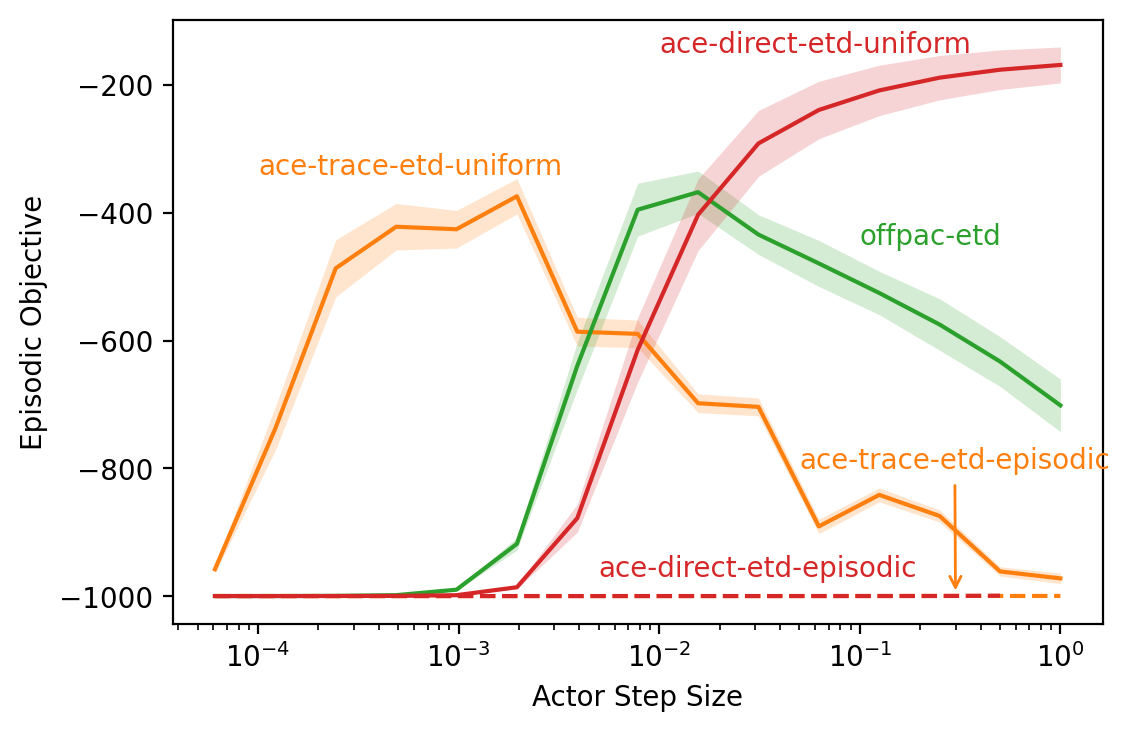

In [239]:
fig, ax = plt.subplots()
for alg in etd_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results'])
    _, num_runs, _, _ = results['results'].shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)

    best_config = np.nanargmax(mean_return)
    
    parameters = results['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10**-2, -150), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.005, -970), color=color)
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10**-4, -340), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.3, -1000), xytext=(.05, -800), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(.1, -450), color=color)
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Episodic Objective')
ax.set_xscale('log')
plt.savefig('mc_epi_etd_sens.png', bbox_inches="tight")

ace-trace-tdrc-episodic -999.8578877887787
ace-trace-tdrc-uniform -311.5342772277228
offpac-tdrc -153.6482178217822
ace-direct-tdrc-episodic -991.2681386138613
ace-direct-tdrc-uniform -153.9553399339934


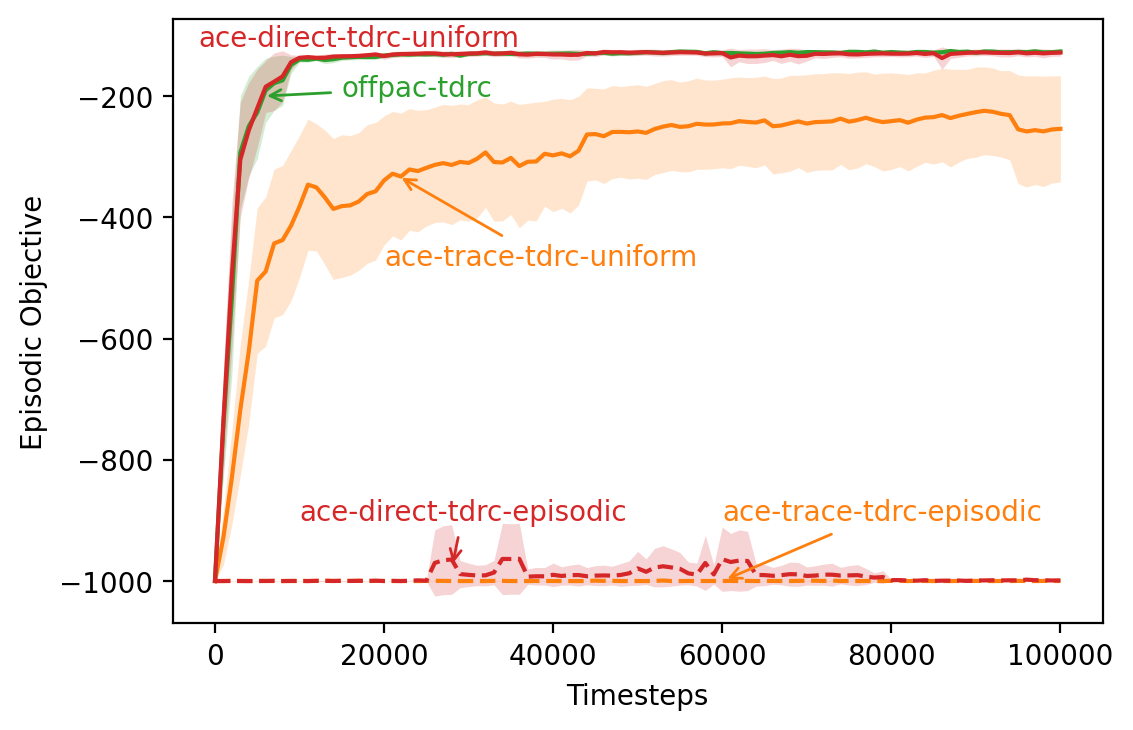

In [240]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results'])
    best_config = np.nanargmax(means.sum(axis=1))
    print(alg, np.nanmax(means.mean(axis=1)))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(-2000, -118), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(28000, -980), xytext=(10000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(21500, -330), xytext=(20000, -480), color=color, arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(60000, -1000), xytext=(60000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(5500, -200), xytext=(15000, -200), color=color, arrowprops=dict(arrowstyle="->", color=color))
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
plt.savefig('mc_epi_tdrc.png', bbox_inches="tight")

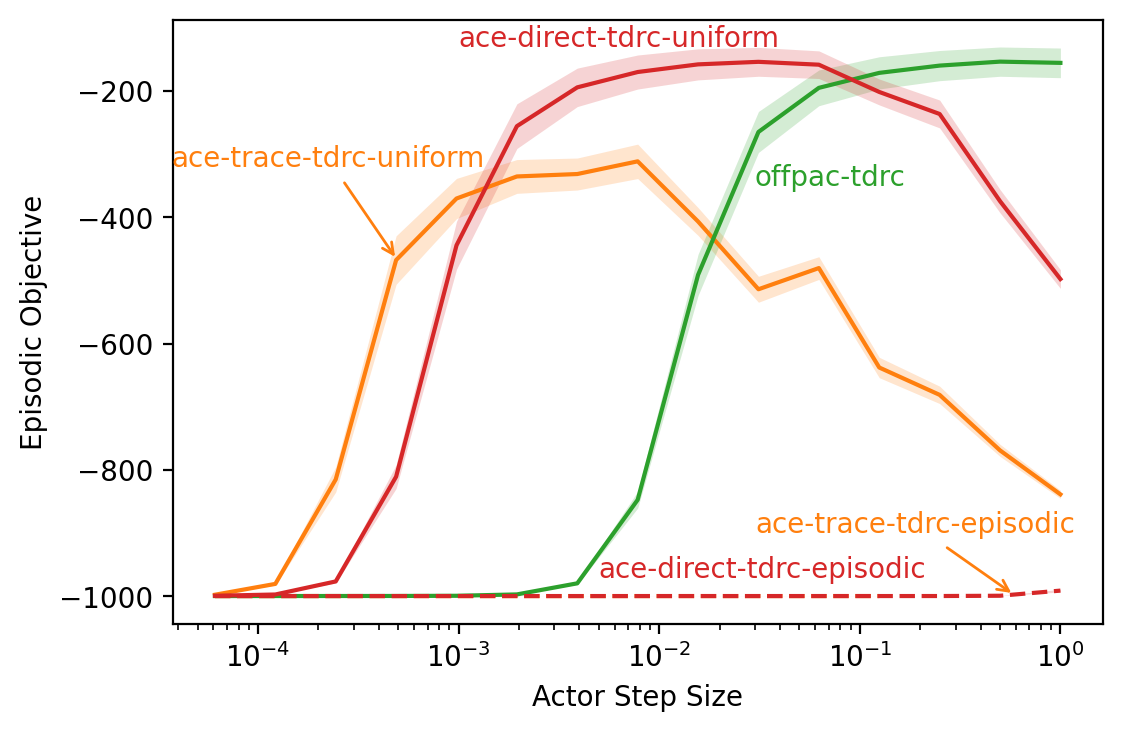

In [172]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results'])
    _, num_runs, _, _ = results['results'].shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)

    best_config = np.nanargmax(mean_return)
    
    parameters = results['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10**-3, -130), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.005, -970), color=color)
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -470), xytext=(.000037, -320), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.6, -1000), xytext=(.03, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(.03, -350), color=color)
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Episodic Objective')
ax.set_xscale('log')
plt.savefig('mc_epi_tdrc_sens.png', bbox_inches="tight")

ace-trace-etd-episodic -979.5460066006601
ace-trace-etd-uniform -295.14298349834985
offpac-etd -255.12701650165013
ace-direct-etd-episodic -970.7391221122114
ace-direct-etd-uniform -114.89952475247526


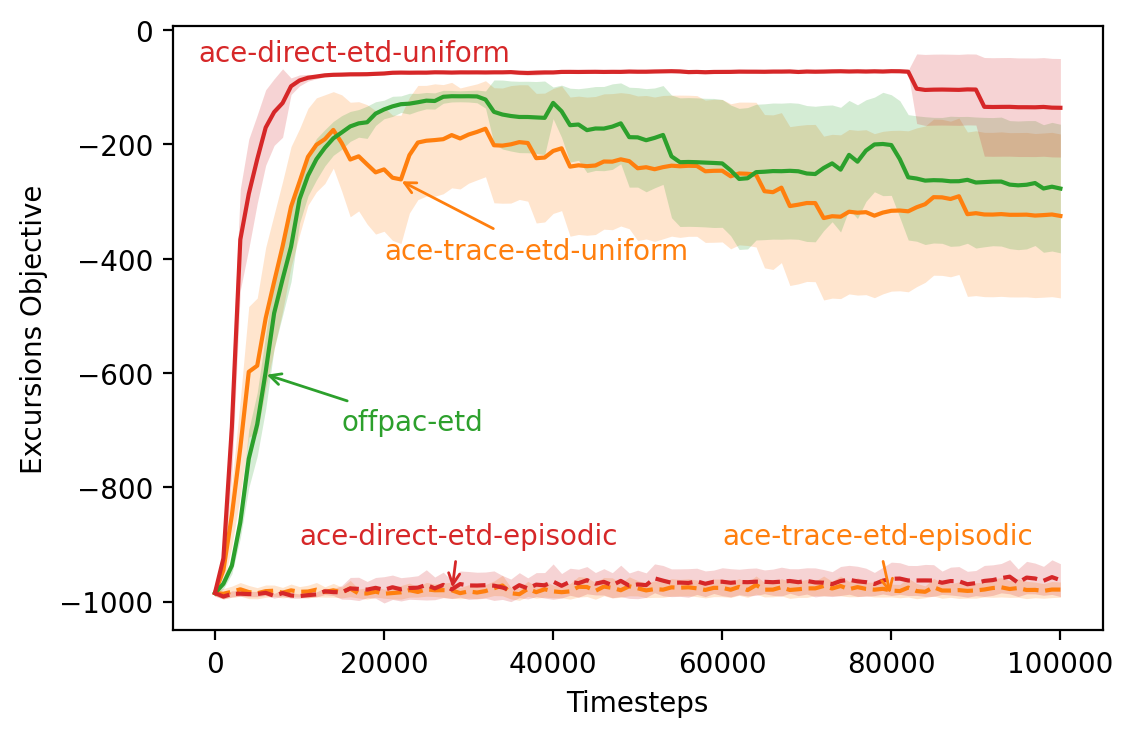

In [241]:
fig, ax = plt.subplots()
for alg in etd_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results_excursions'])
    best_config = np.nanargmax(means.sum(axis=1))
    print(alg, np.nanmax(means.mean(axis=1)))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(-2000, -55), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(28000, -985), xytext=(10000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(21500, -260), xytext=(20000, -400), color=color, arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(80000, -995), xytext=(60000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(5500, -600), xytext=(15000, -700), color=color, arrowprops=dict(arrowstyle="->", color=color))
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
plt.savefig('mc_exc_etd.png', bbox_inches="tight")

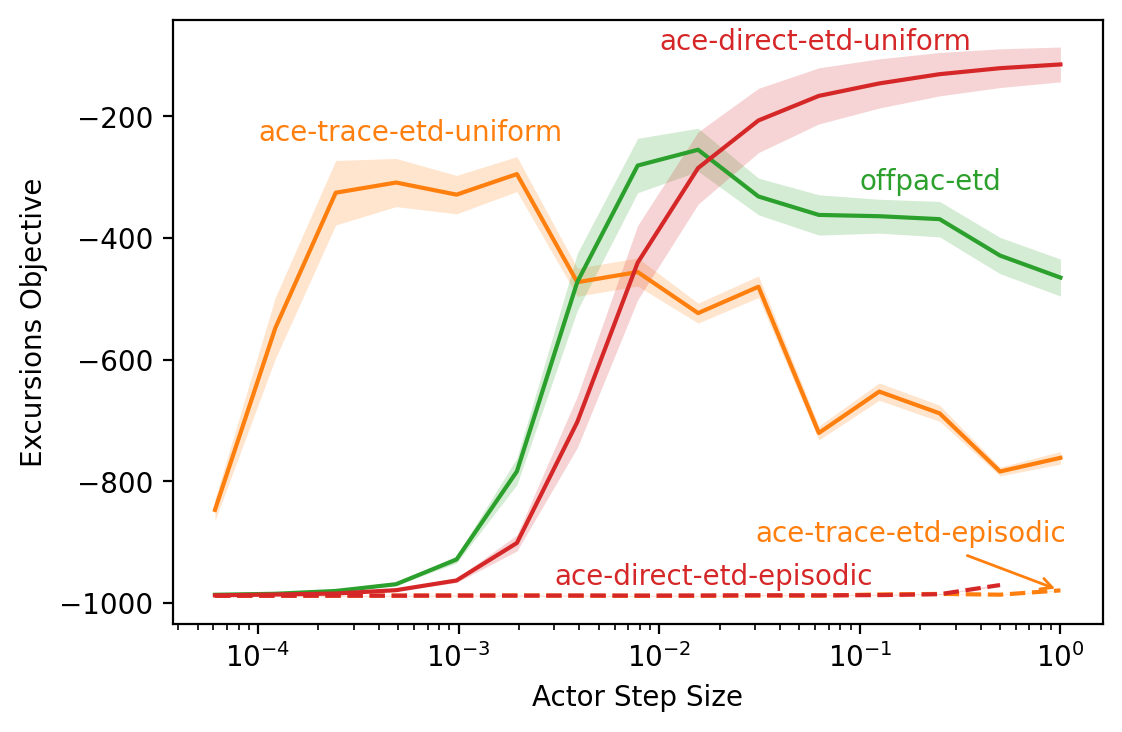

In [242]:
fig, ax = plt.subplots()
for alg in etd_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results_excursions'])
    _, num_runs, _, _ = results['results'].shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = results['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10**-2, -90), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.003, -970), color=color)
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0001, -240))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(1, -980), xytext=(.03, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(.1, -320), color=color)
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Excursions Objective')
ax.set_xscale('log')
plt.savefig('mc_exc_etd_sens.png', bbox_inches="tight")

ace-trace-tdrc-episodic -987.7335379537955
ace-trace-tdrc-uniform -184.75519471947197
offpac-tdrc -99.59949174917493
ace-direct-tdrc-episodic -953.8808118811882
ace-direct-tdrc-uniform -101.19089108910893


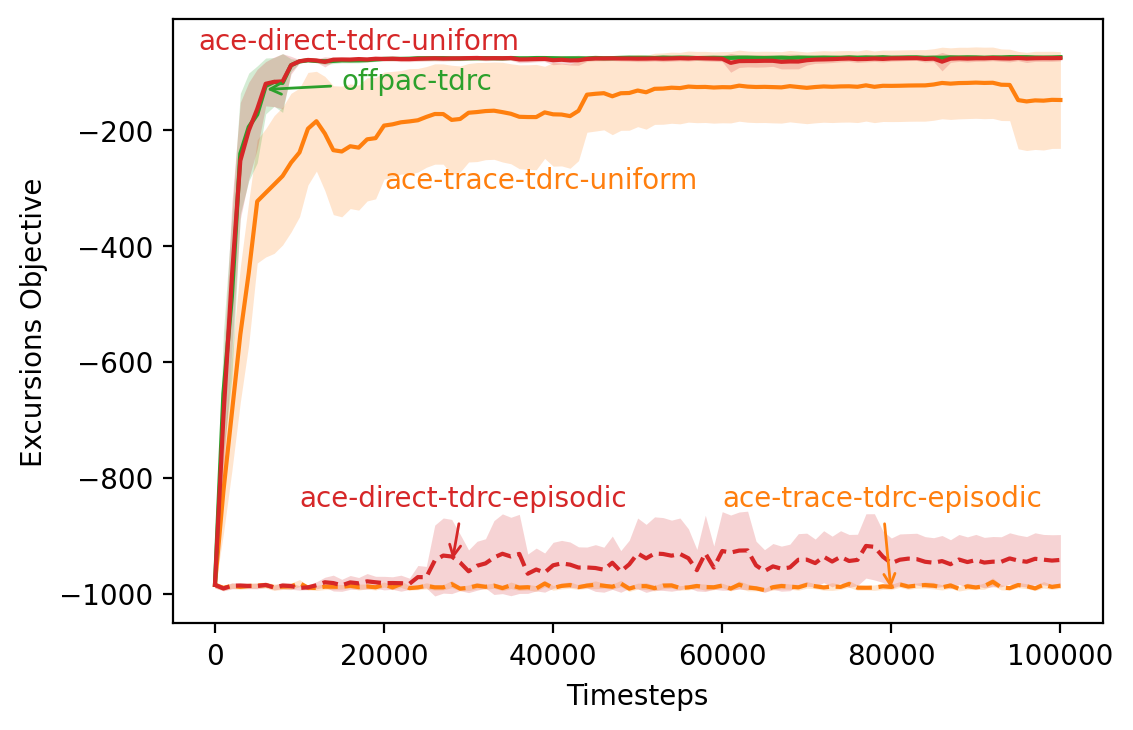

In [243]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['results_excursions'])
    best_config = np.nanargmax(means.sum(axis=1))
    print(alg, np.nanmax(means.mean(axis=1)))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(-2000, -60), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(28000, -950), xytext=(10000, -850), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(20000, -300))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(80000, -1000), xytext=(60000, -850), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(5500, -130), xytext=(15000, -130), color=color, arrowprops=dict(arrowstyle="->", color=color))
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
plt.savefig('mc_exc_tdrc.png', bbox_inches="tight")

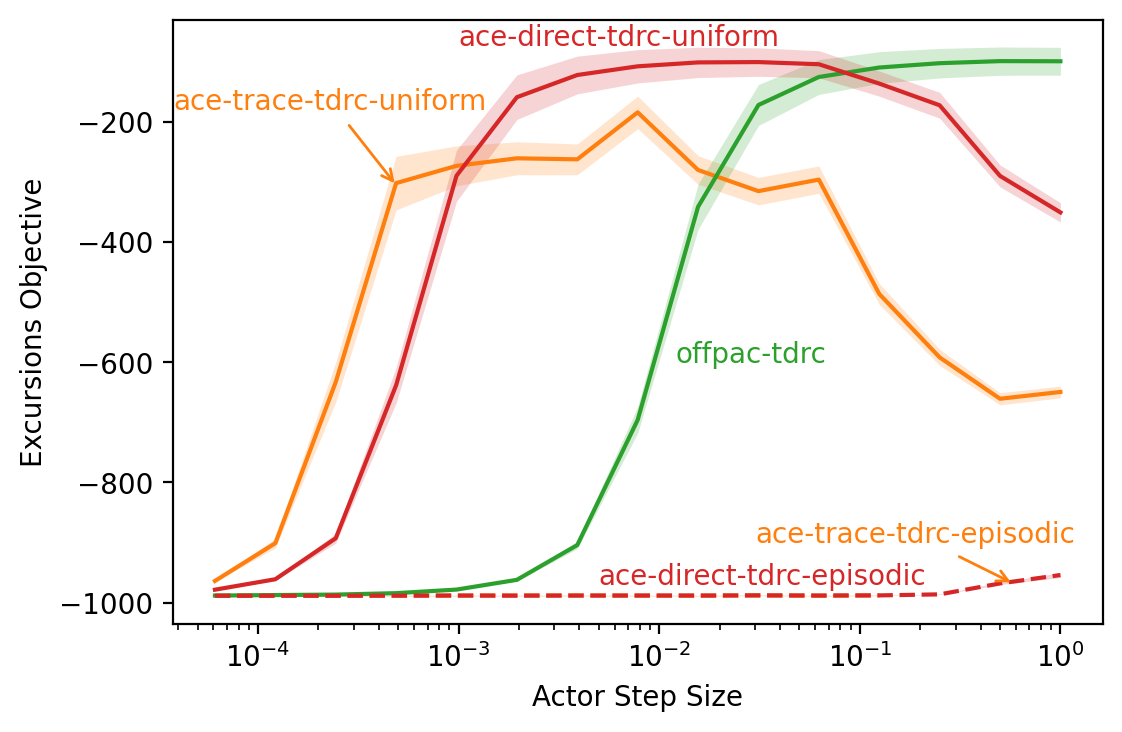

In [244]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    num_configs, num_runs, num_policies, num_evals = results['results_excursions'].shape
    means, lower, upper = combine_results(results['results_excursions'])
    _, num_runs, _, _ = results['results'].shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = results['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10**-3, -73), color=color)
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.005, -970), color=color)
    elif 'ace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -310), xytext=(.000038, -180), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, xy=(.6, -970), xytext=(.03, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, xy=(.012, -600), color=color)
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Excursions Objective')
ax.set_xscale('log')
plt.savefig('mc_exc_tdrc_sens.png', bbox_inches="tight")

In [ ]:
# # Print the best-performing parameters for each method:
# algs = etd_algs + tdrc_algs
# for alg in algs:
#     results = load_results(alg)
#     means, lower, upper = combine_results(results['results'])
#     best_config = np.nanargmax(means.sum(axis=1))
#     parameters = results['parameters']
#     print(alg, parameters[best_config])

# print(parameters.dtype.names)
# #     mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
# #             (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
# #             (parameters['lambda'] == parameters[best_config]['lambda'])
# #     sorted_indices = np.argsort(parameters[mask]['alpha_a'])

In [15]:
alg = 'ace-direct-etd-uniform'
results = load_results(alg)
means, lower, upper = combine_results(results['results_excursions'])
print(means.shape)

mean_return = np.mean(means, axis=1)
sem_return = st.sem(means, axis=1)

best_config = np.nanargmax(mean_return)
# print(np.nanmax(mean_return))

parameters = results['parameters']
mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
        (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
        (parameters['lambda'] == parameters[best_config]['lambda'])
sorted_indices = np.argsort(parameters[mask]['alpha_a'])
x = parameters[mask]['alpha_a'][sorted_indices]
print(x)
y = mean_return[mask][sorted_indices]
print(y)

(15, 101)
[6.10351562e-05 1.22070312e-04 2.44140625e-04 4.88281250e-04
 9.76562500e-04 1.95312500e-03 3.90625000e-03 7.81250000e-03
 1.56250000e-02 3.12500000e-02 6.25000000e-02 1.25000000e-01
 2.50000000e-01 5.00000000e-01 1.00000000e+00]
[-987.69330693 -986.28221122 -984.69739934 -979.15911551 -963.21711551
 -901.55139274 -702.69344554 -440.7460462  -285.22511551 -206.98930693
 -166.5979934  -146.11828383 -130.9089901  -121.06127393 -114.89952475]


In [16]:
experience = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/mountain-car/ace-direct-etd-uniform/experience_test.npy', mode='r')
states = []
for run in experience:
    for state in run:
        states.append(*state)
states = np.array(states).T
# print(states)

(30, 50)


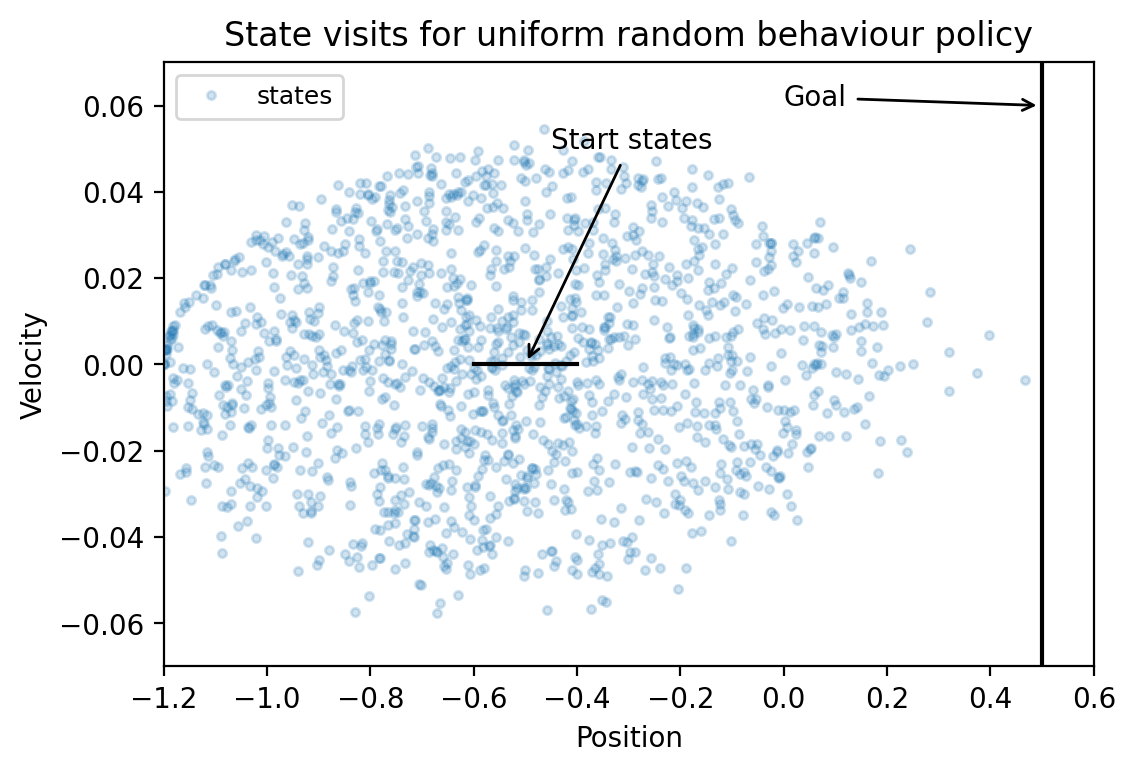

In [19]:
import gym

experience = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/mountain-car-final/offpac-etd/experience_test.npy', mode='r')
print(experience.shape)
states = []
for run in experience:
    for state in run:
        states.append(*state)
states = np.array(states).T

mc = gym.make('MountainCar-v0').unwrapped
fig = plt.figure()
ax = fig.gca()
ax.plot(states[0], states[1], '.', alpha=.2, label='states')
plt.title('State visits for uniform random behaviour policy')
plt.xlabel('Position')
plt.xlim(mc.min_position, mc.max_position)
plt.ylabel('Velocity')
plt.ylim(-mc.max_speed, mc.max_speed)
ax.plot((-.6,-.4), (0,0), color='black')
ax.annotate('Start states', xy=(-.5,0), xytext=(-.45, .05), arrowprops=dict(arrowstyle='->'))
plt.axvline(x=mc.goal_position, color='black')  # Plot the goal position.
ax.annotate('Goal', xy=(mc.goal_position, .06), xytext=(.0, .06), arrowprops=dict(arrowstyle='->'))
plt.legend(loc='upper left')
mc.close()
plt.show()

In [ ]:
# # Do any of the offpac runs diverge?
# op_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/offpac/concatenated_performance.npy', mode='r')
# op_results = op_memmap['performance']['results']
# op_num_configs, op_num_runs, op_num_policies, op_num_eval_runs = op_results.shape

# print(np.isnan(op_memmap['performance']).sum() / op_results)

# # op_parameters = op_memmap['parameters']

In [ ]:
# print(np.isnan(op_mean_results).any(axis=1).sum())
# print(op_parameters.dtype.names)
# print(op_parameters[np.isnan(op_mean_results).any(axis=1)])